# SciPy

[![Index](https://img.shields.io/badge/Index-blue)](../index.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/digillia/Digillia-Colab/blob/main/tools/scipy.ipynb)

SciPy est une bibliothèque open-source en Python, dédiée au calcul scientifique et technique. Elle fournit des outils performants pour résoudre des problèmes mathématiques complexes, comme l’optimisation, l’intégration, les équations différentielles, l’interpolation et l’algèbre linéaire. SciPy s’appuie sur [NumPy](https://numpy.org/), qui gère les structures de données numériques, et l’étend avec des fonctionnalités supplémentaires pour des applications plus avancées en ingénierie, physique, mathématiques appliquées, et autres domaines scientifiques.

Docs:
- https://github.com/scipy/scipy
- https://scipy.org/

In [93]:
import os
import sys

# Supprimer les commentaires pour installer (requirements.txt)
# !pip3 install -q -U numpy
# !pip3 install -q -U pandas
# !pip3 install -q -U matplotlib
# !pip3 install -q -U scipy

# À installer dans tous les cas pour Google Colab et Github
if 'google.colab' in sys.modules or 'CI' in os.environ:
    !pip3 install -q -U yfinance

In [94]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Obtention des données

In [95]:
tickers = ['SPY', 'QQQ', 'AGG', 'BND', 'GLD']

# Une première façon d'obtenir les cours de bourse
# df = yf.download(tickers, period='10y', interval='1d')['Adj Close']

# Une deuxième façon d'obtenir les cours de bourse
# Quand auto_adjust == True, Close est identique à Adj Close (inclus les dividendes, etc.)
# Voir https://help.yahoo.com/kb/adjusted-close-sln28256.html et https://github.com/ranaroussi/yfinance/issues/1333
t = yf.Tickers(tickers)
df = t.history(period='10y', interval='1d', auto_adjust=True)

# Conversion de l'index
df.index = df.index.tz_localize(None).to_period('D')

df.head()

[*********************100%***********************]  5 of 5 completed


Price      Capital Gains                          Close             \
Ticker               AGG  BND  GLD  QQQ  SPY        AGG        BND   
Date                                                                 
2014-10-22           0.0  0.0  0.0  0.0  0.0  85.454910  62.964161   
2014-10-23           0.0  0.0  0.0  0.0  0.0  85.253822  62.774136   
2014-10-24           0.0  0.0  0.0  0.0  0.0  85.284721  62.827370   
2014-10-27           0.0  0.0  0.0  0.0  0.0  85.315643  62.804569   
2014-10-28           0.0  0.0  0.0  0.0  0.0  85.184196  62.766586   

Price                                          ... Stock Splits            \
Ticker             GLD        QQQ         SPY  ...          AGG  BND  GLD   
Date                                           ...                          
2014-10-22  119.339996  88.997177  161.542572  ...          0.0  0.0  0.0   
2014-10-23  118.519997  90.336258  163.420532  ...          0.0  0.0  0.0   
2014-10-24  118.349998  91.075058  164.678055  ...          0.0  0.0  0.0   
2014-10-27  118.059998  91.139694  164.451721  ...          0.0  0.0  0.0   
2014-10-28  118.099998  92.515671  166.337982  ...          0.0  0.0  0.0   

Price                  Volume                                         
Ticker      QQQ  SPY      AGG      BND      GLD       QQQ        SPY  
Date                                                                  
2014-10-22  0.0  0.0  3179200  2292400  3740200  39178000  151822000  
2014-10-23  0.0  0.0  1863100  6617200  6417500  48123800  154944000  
2014-10-24  0.0  0.0  1188900  2202100  3610600  43157600  117927000  
2014-10-27  0.0  0.0  1073100  2454200  2443600  29545700   82954000  
2014-10-28  0.0  0.0  1128600  2201200  3260100  34495100  106736000  

[5 rows x 40 columns]

## Calcul des rendements

In [96]:
returns = df['Close'].pct_change().dropna()
returns.head()

Ticker,AGG,BND,GLD,QQQ,SPY
Date,,,,,
2014-10-23,-0.002353,-0.003018,-0.006871,0.015046,0.011625
2014-10-24,0.000362,0.000848,-0.001434,0.008178,0.007695
2014-10-27,0.000363,-0.000363,-0.002450,0.000710,-0.001374
2014-10-28,-0.001541,-0.000605,0.000339,0.015097,0.011470
2014-10-29,-0.002179,-0.001695,-0.014310,-0.003693,-0.001512


## Graphe de comparaison des rendements sur une base 100

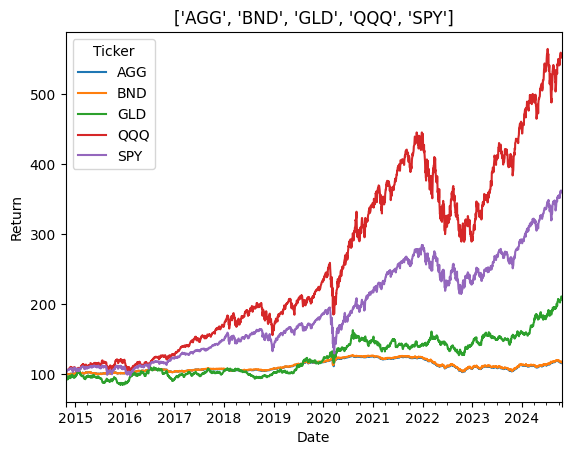

In [97]:
def plot(r):
    data = 100 * (r+1).cumprod()
    plot = data.plot()
    plot.set_title(data.columns.to_list())
    plot.set_ylabel('Return')

plot(returns)

## Annualisation des rendements

In [98]:
def annualize_returns(r):
    if returns.index.freqstr == 'D':
        periods_per_year = 252
    elif returns.index.freqstr == 'M':
        periods_per_year = 12
    elif returns.index.freqstr == 'Q':
        periods_per_year = 4
    elif returns.index.freqstr == 'A':
        periods_per_year = 1
    else:
        raise ValueError("Unsupported frequency: {}".format(returns.index.freqstr))
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

ar = annualize_returns(returns)
ar

Ticker
AGG    0.014677
BND    0.015402
GLD    0.077435
QQQ    0.187703
SPY    0.137355
dtype: float64

## Matrice de covariance

In [99]:
cov_matrix = returns.cov()
cov_matrix

Ticker,AGG,BND,GLD,QQQ,SPY
Ticker,,,,,
AGG,0.000011,0.000011,0.000011,0.000005,0.000003
BND,0.000011,0.000012,0.000011,0.000005,0.000004
GLD,0.000011,0.000011,0.000080,0.000006,0.000004
QQQ,0.000005,0.000005,0.000006,0.000188,0.000141
SPY,0.000003,0.000004,0.000004,0.000141,0.000123


## Fonctions de calcul du rendement et de la volatilité d'un portefeuille

In [100]:
# Portefeuille défini par un ensemble de poids w et un ensemble de rendements annualisés r
def portfolio_return(w, r):
    return w.T @ r

# Portefeuille défini par un ensemble de poids w et une matrice de covariance cov
def portfolio_volatility(w, cov):
    return (w.T @ cov @ w)**0.5

# Cas du portefeuille avec poids égaux
n = len(returns.columns)
eq_weights = np.repeat(1/n, n)
print('Return:', portfolio_return(eq_weights, ar))
print('Volatility:', portfolio_volatility(eq_weights, cov_matrix))

Return: 0.08651433954167494
Volatility: 0.005712572115586589


## Fonction de minimisation de la votalilité ave SciPy

In [101]:
# Obtention des poids du portefeuille pour minimiser la volatilité considérant le rendement visé (risque pris)
def minimize_volatility(target_return, r, cov):
    n = r.shape[0]
    init_guess = np.repeat(1/n, n)
    # Contrainte: poids entre 0 et 1 (pas de poids négatifs)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # Contrainte: somme des poids == 1 (tout est investi)
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda w: np.sum(w) - 1
    }
    # Contrainte: rendement visé == rendement portefeuille
    portfolio_return = lambda w, r: np.sum(r * w)
    return_is_target = {'type': 'eq',
                        'args': (r,),
                        'fun': lambda w, r: target_return - portfolio_return(w, r)
    }
    # Optimisation avec SciPy
    weights = minimize(portfolio_volatility, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1, return_is_target),
                       bounds=bounds)
    return weights.x

minimize_volatility(0.2, ar, cov_matrix)

array([2.15520999e-17, 6.94619022e-17, 8.30287298e-18, 1.00000000e+00,
       5.99956958e-13])

In [102]:
# Obtention des poids du portefeuille MSR (Max Sharpe Ratio)
def msr(riskfree_rate, r, cov):
    n = r.shape[0]
    init_guess = np.repeat(1/n, n)
    # Contrainte: poids entre 0 et 1 (pas de poids négatifs)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # Contrainte: somme des poids == 1 (tout est investi)
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda w: np.sum(w) - 1
    }
    # Fonction de ratio Sharpe à minimiser (négatif pour maximiser)
    def neg_sharpe(w, riskfree_rate, r, cov):
        pr = portfolio_return(w, r)
        vol = portfolio_volatility(w, cov)
        return -(pr - riskfree_rate)/vol
    # Optimisation avec SciPy
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, r, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

msr(0.03, ar, cov_matrix)

array([0.00000000e+00, 4.94592235e-16, 3.90148838e-01, 6.09851162e-01,
       2.25572952e-16])

In [103]:
# Obention des poids du portefeuille GMV (Global Minimum Volatility)
def gmv(cov):
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

gmv(cov_matrix)

array([7.63257317e-01, 1.76902457e-01, 0.00000000e+00, 2.26797439e-11,
       5.98402260e-02])

In [104]:
# Obtention d'une liste de points sur la frontière efficiente de Markowitz
def optimal_weights(n_points, r, cov):
    target_rs = np.linspace(r.min(), r.max(), n_points)
    weights = [minimize_volatility(target_return, r, cov) for target_return in target_rs]
    return weights

optimal_weights(30, ar, cov_matrix)

[array([9.99999770e-01, 2.30259425e-07, 0.00000000e+00, 0.00000000e+00,
        1.14630527e-14]),
 array([0.48178595, 0.47384282, 0.        , 0.00356588, 0.04080535]),
 array([0.45344915, 0.44710102, 0.02222262, 0.01469749, 0.06252973]),
 array([0.42212613, 0.41662791, 0.05156516, 0.0179885 , 0.0916923 ]),
 array([0.39221173, 0.38732647, 0.07565132, 0.02129403, 0.12351646]),
 array([0.36375805, 0.35942697, 0.10439612, 0.03709876, 0.13532011]),
 array([0.33756534, 0.33368287, 0.13097452, 0.06105503, 0.13672224]),
 array([0.31193311, 0.30842446, 0.15582571, 0.08549783, 0.1383189 ]),
 array([0.27461684, 0.27384576, 0.2106585 , 0.0945773 , 0.14630159]),
 array([0.25608141, 0.25549739, 0.20831587, 0.12068595, 0.15941939]),
 array([0.23754598, 0.23714901, 0.20597323, 0.1467946 , 0.17253718]),
 array([0.20534668, 0.20349769, 0.27017893, 0.18174295, 0.13923374]),
 array([0.17938348, 0.17806815, 0.29513341, 0.20508772, 0.14232724]),
 array([0.15302392, 0.15216777, 0.32219685, 0.22883616, 0.1437

<Axes: xlabel='Volatility'>

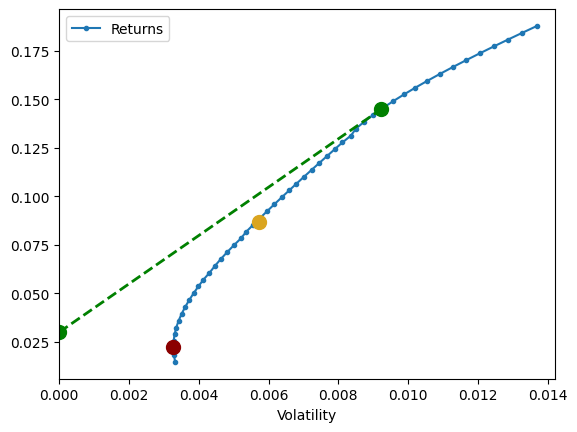

In [105]:
# Graphe de la frontière efficiente de Markowitz
def plot_ef(n_points, r, cov, style='.-', legend=True, show_cml=True, riskfree_rate=0, show_ew=True, show_gmv=True):
    # Obtention de points sur la frontière
    weights = optimal_weights(n_points, r, cov)
    ef = pd.DataFrame({
        "Volatility": [portfolio_volatility(w, cov) for w in weights],
        "Returns": [portfolio_return(w, r) for w in weights], 
    })
    # Graphe de la frontière
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend)
    ax.set_xlim(left = 0)
    
    if show_cml:
        # Affichage du portefeuille MSR
        w_msr = msr(riskfree_rate, r, cov)
        r_msr = portfolio_return(w_msr, r)
        vol_msr = portfolio_volatility(w_msr, cov)
        # Affichage de la CML (Capital Market Line)
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
    if show_ew:
        # Affichage du portefeuille à poids égaux
        n = r.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, r)
        vol_ew = portfolio_volatility(w_ew, cov)
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
    if show_gmv:
        # Affichage du portefeuille GMV
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, r)
        vol_gmv = portfolio_volatility(w_gmv, cov)
        ax.plot([vol_gmv], [r_gmv], color='darkred', marker='o', markersize=10)
        
        return ax
    
plot_ef(50, ar, cov_matrix, riskfree_rate=0.03)

         EW           GMV           MSR
Ticker                                 
AGG     0.2  7.632573e-01  0.000000e+00
BND     0.2  1.769025e-01  4.945922e-16
GLD     0.2  0.000000e+00  3.901488e-01
QQQ     0.2  2.267974e-11  6.098512e-01
SPY     0.2  5.984023e-02  2.255730e-16


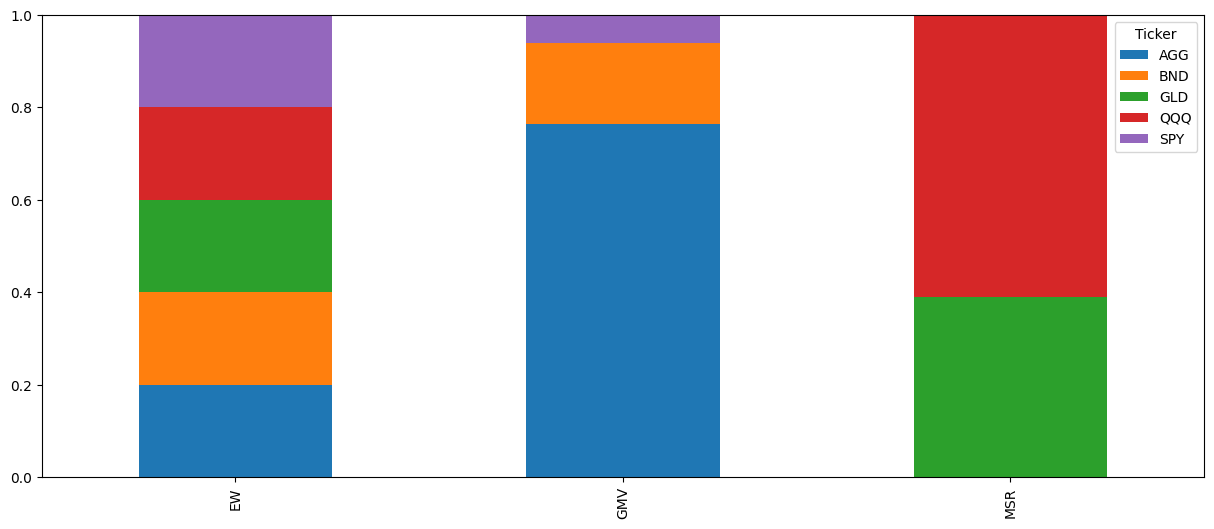

In [106]:
def plot_w(r, cov, riskfree_rate=0):
    n = r.shape[0]
    wts = pd.DataFrame(
        data={
            "EW": np.repeat(1/n, n),
            "GMV": gmv(cov),
            "MSR": msr(riskfree_rate, r, cov)
        },
        index=r.index
    )
    print(wts)
    wts.T.plot.bar(stacked=True, figsize=(15,6), legend=True);

plot_w(ar, cov_matrix, 0.03)
